In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds

using Gen
import GenPOMDPs
import GenParticleFilters
const GPF = GenParticleFilters

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


GenParticleFilters

In [2]:
using GenSMCP3

# We need this to help with dualizing and undualizing values...
const DFD = GenSMCP3.GenTraceKernelDSL.DynamicForwardDiff

DynamicForwardDiff

In [3]:
_segs, _boxes, _bb, _center, _xs, _hds, _ps, _dxs, _dhds, _us, _T = L.load_env();

PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; σ = 0.2),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.2,
            outlier      = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [4]:
### Initial model ###
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

### Motion model ###
# The next position, under a 0-noise model, with no walls.
function det_next_pos((x, y), a)
    a == :up    ? [x, y + 1] :
    a == :down  ? [x, y - 1] : 
    a == :left  ? [x - 1, y] :
    a == :right ? [x + 1, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(DFD.value(prev), DFD.value(new))
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end
@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action)
    pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, pos, PARAMS.map)
    
    return next_pos
end

### Observation model ###

@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    # segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], params.map; num_a=params.obs.n_rays, zmax)
    @assert !any(isinf.(zs))
    # zs = reshape(dists, (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]
    @assert !any(isinf.(ỹ))

    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  

    @assert !any(any(isinf.(o)) for o in obs) "ỹ = $ỹ"
    
    return obs
end;

@load_generated_functions()

In [5]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#394"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [6]:
tr = generate(trajectory_model, (
        15,
        [
            :down, :down,
            :right, :right,
            :down, :down, :down, :down,
            :down, :right, :right, :right, :right,
            :down, :down, :right, :right
        ],
        PARAMS,
    ), choicemap((GenPOMDPs.state_addr(0, :pos), [5., 17.]))
)[1];

┌ Info: Saved animation to /var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_pa1uv2xWts.gif
└ @ Plots /Users/georgematheos/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_pa1uv2xWts.gif")
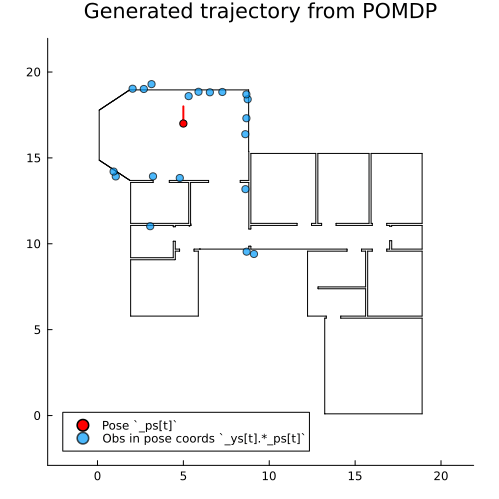

In [7]:
using Random
# -----------------------
poses = [
    L.Pose(position, PARAMS.orientation)
    for position in GenPOMDPs.state_sequence(tr)
];
ptclouds = [
    obss[:obs].*pose
    for (obss, pose) in zip(
        GenPOMDPs.observation_sequence(tr),
        poses
    )
];
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)
    p = poses[t]
    y = ptclouds[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

In [33]:
_example_grid_args = (;
    tau = 1., # "temperature" for grid proposal
    pmin = 1e-6,
    init_grid_args = (;
        k = [9, 9],    # number of grid cells along each dimension
        r = [0.5, 0.5] # size of grid cells at first iteration
    ),
    n_iters = 3, # number of iterations of grid proposals
    initial_pos = [8., 8.] # center of grid for first timestep
)

import GenPOMDPs: state_addr

# SMCP3 forward proposal
GenSMCP3.@kernel function forward_iterated_grid_proposal(tr, is_initial_step, params, new_action, new_obs, grid_args)
    if is_initial_step
        T = 0
        pos = grid_args.initial_pos
    else
        T_prev, actions, params_ = get_args(tr)
        @assert params_ == params # we have to pass in `params` since we can't get it otherwise for the initial step
        T = T_prev + 1

        # Form the grid around what would be the position of the agent at the next timestep
        # in the determinized version of the motion model.
        pos = det_next_pos(tr[state_addr(T_prev, :pos)], new_action)
    end

    j, args, grid_proposed_positions = nothing, nothing, nothing # make these available outside loop scope
    for i = 1:grid_args.n_iters
        args = L.grid_schedule(grid_args.init_grid_args, i)
        
        grid_proposed_positions, _ = L.vector_grid(GenSMCP3.GenTraceKernelDSL.DynamicForwardDiff.value(pos), args...)

        if !is_initial_step
            # Get the logprobs under the motion model.  Also get the final
            # position the agent will end up at if each given position is sampled.
            # (This may not equal the sampled position, due to wall collisions.)
            motion_logprobs_rets = [
                Gen.assess(motion_model, (DFD.value(pos), new_action, params), choicemap((:pos, DFD.value(newpos))))
                for newpos in reshape(grid_proposed_positions, (:,))
            ]
            motion_logprobs = [logp for (logp, r) in motion_logprobs_rets]
            # grid_final_positions = [r for (logp, r) in motion_logprobs_rets]
            grid_final_positions = reshape(grid_proposed_positions, (:,))
        else
            motion_logprobs = [0. for _ in reshape(grid_proposed_positions, (:,))]
            grid_final_positions = grid_proposed_positions
        end

        # Evaluate the observation probabilities.
        poses = [L.Pose(p, params.orientation) for p in grid_final_positions]
        _segs = params.map
        _as = L.create_angles(params.obs.fov, params.obs.n_rays)
        log_obs_probs,  = L.eval_pose_vectors(
            Vector.(poses)::Array{Vector{Float64}},
            new_obs::Vector{Vector{Float64}},
            _segs::Vector{L.Segment},
            params.obs.sensor_args...; sorted=false,
            fov=params.obs.fov, num_a=params.obs.n_rays
        )

        # Sample a next position from the grid.
        # println("size(log_obs_probs): ", size(log_obs_probs))
        # println("size(motion_logprobs): ", size(motion_logprobs))
        # println("log_obs_probs: ", log_obs_probs)
        # println("motion_logprobs: ", motion_logprobs)
        # println("positions = ", grid_final_positions)
        # println("obs = ", new_obs)
        log_ps = log_obs_probs .+ motion_logprobs
        log_ps_tau = log_ps ./ grid_args.tau
        probs      = L.normalize_exp(log_ps_tau)
        probs      = L.raise_probs(probs, grid_args.pmin)
        j = {(:j, i)} ~ categorical(probs)
        pos = grid_final_positions[j]

        # println("sampled pos: $pos ; probability: $(probs[j]), logp_obs: $(log_obs_probs[j]), logp_motion: $(motion_logprobs[j])")
    end

    # Sample the final position in continuous space.
    vs = grid_proposed_positions
    # println("bounds for uniform draw: ", vs[j][1:2] -  args.r[1:2]/2, vs[j][1:2] + args.r[1:2]/2)
    x′  = {:pos}  ~ mvuniform(vs[j][1:2] -  args.r[1:2]/2, vs[j][1:2] + args.r[1:2]/2)

    # println("setting $((state_addr(T, :pos))) to $x′")
    return (
        choicemap((state_addr(T, :pos), x′)),
        EmptyChoiceMap() # Backward proposal is deterministic.
    )
end

# SMCP3 backward proposal
GenSMCP3.@kernel function backward_iterated_grid_proposal(tr, is_initial_step, grid_args)
    (T, actions, params) = get_args(tr)
    new_action = T > 0 ? actions[T] : nothing
    T_prev = T - 1

    fwd_ch = choicemap()

    nextpos = tr[state_addr(T, :pos)]
    fwd_ch[:pos] = nextpos

    if is_initial_step
        nextpos_det = grid_args.initial_pos
    else
        nextpos_det = det_next_pos(tr[state_addr(T_prev, :pos)], new_action)
    end

    # Step backward through the grid proposals, with the inverted schedule.
    for i=grid_args.n_iters:1
        args = L.grid_schedule(grid_args.init_grid_args, i)
        j = L.grid_index(nexpos, nextpos_det, args...; linear=true)
        fwd_ch[(:j, i)] = j
    end
    
    return (
        EmptyChoiceMap(), # The old trace just drops values; no constraints needed.
        fwd_ch
    )
end

GenTraceKernelDSL.Kernel(var"#144#145"())

In [42]:
_grid_args = (;
    tau = 1., # "temperature" for grid proposal
    pmin = 1e-6,
    init_grid_args = (;
        k = [9, 9],    # number of grid cells along each dimension
        r = [.5, .5] # size of grid cells at first iteration
    ),
    n_iters = 3 # number of iterations of grid proposals
)

_t0_grid_args = (;
    _grid_args...,
    n_iters=5, # more iterations for the initial step

    # TODO: set this up to automatically look at the bounding box
    init_grid_args = (; k=[9, 9], r=[2., 2.]),
    initial_pos = [9.5, 9.5] # center of grid for first timestep
)

(pf_init, pf_step) = GenPOMDPs.pf(
    pomdp, PARAMS,
    obs -> ( # Initialize via a 3-particle SMCP3 proposal.
        3, # n particles
        SMCP3Update(
            forward_iterated_grid_proposal, backward_iterated_grid_proposal,
            # is_initial_step, params, new_action, new_obs, grid_args
            (true, PARAMS, nothing, obs[:obs], _t0_grid_args), # no action before the initial observation
            # is_initial_step, grid_args
            (true, _t0_grid_args,)
        )
    ),
    (action, obs) -> ( # Update with the SMCP3 proposal.
        SMCP3Update(
            forward_iterated_grid_proposal, backward_iterated_grid_proposal,
            # is_initial_step, params, new_action, new_obs, grid_args
            (false, PARAMS, action, obs[:obs], _grid_args),
            # is_initial_step, grid_args
            (false, _grid_args,)
        ),
    )
);

In [43]:
states = []
state = pf_init(GenPOMDPs.observation_sequence(tr)[1]);
push!(states, state)
for (a, obs) in zip(
        GenPOMDPs.action_sequence(tr)[2:end],
        GenPOMDPs.observation_sequence(tr)[2:end]
    )
    state = pf_step(state, a, obs)
    push!(states, state)
end
;

┌ Info: Saved animation to /var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_9Mz8taNadM.gif
└ @ Plots /Users/georgematheos/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_9Mz8taNadM.gif")
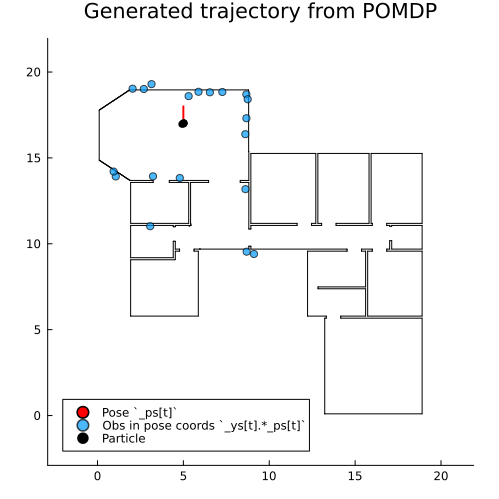

In [44]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
# states = [state]
for t=0:1:length(states)-1
    p = poses[t + 1]
    y = ptclouds[t + 1]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    particles = states[t + 1]
    labeled=false
    for (w, tr) in zip(
            GenParticleFilters.get_norm_weights(particles),
            GenParticleFilters.get_traces(particles)
        )
        pos = tr[GenPOMDPs.state_addr(t)]
        if !labeled
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label="Particle")
            labeled=true
        else
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label=nothing)
        end
    end

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

In [45]:
length(states)

16

# Scratch work below here

In [77]:
positions_str = "[[1.5, 1.5] [1.5, 3.5] [1.5, 5.5] [1.5, 7.5] [1.5, 9.5] [1.5, 11.5] [1.5, 13.5] [1.5, 15.5] [1.5, 17.5]; [3.5, 1.5] [3.5, 3.5] [3.5, 5.5] [3.5, 7.5] [3.5, 9.5] [3.5, 11.5] [3.5, 13.5] [3.5, 15.5] [3.5, 17.5]; [5.5, 1.5] [5.5, 3.5] [5.5, 5.5] [5.5, 7.5] [5.5, 9.5] [5.5, 11.5] [5.5, 13.5] [5.5, 15.5] [5.5, 17.5]; [7.5, 1.5] [7.5, 3.5] [7.5, 5.5] [7.5, 7.5] [7.5, 9.5] [7.5, 11.5] [7.5, 13.5] [7.5, 15.5] [7.5, 17.5]; [9.5, 1.5] [9.5, 3.5] [9.5, 5.5] [9.5, 7.5] [9.5, 9.5] [9.5, 11.5] [9.5, 13.5] [9.5, 15.5] [9.5, 17.5]; [11.5, 1.5] [11.5, 3.5] [11.5, 5.5] [11.5, 7.5] [11.5, 9.5] [11.5, 11.5] [11.5, 13.5] [11.5, 15.5] [11.5, 17.5]; [13.5, 1.5] [13.5, 3.5] [13.5, 5.5] [13.5, 7.5] [13.5, 9.5] [13.5, 11.5] [13.5, 13.5] [13.5, 15.5] [13.5, 17.5]; [15.5, 1.5] [15.5, 3.5] [15.5, 5.5] [15.5, 7.5] [15.5, 9.5] [15.5, 11.5] [15.5, 13.5] [15.5, 15.5] [15.5, 17.5]; [17.5, 1.5] [17.5, 3.5] [17.5, 5.5] [17.5, 7.5] [17.5, 9.5] [17.5, 11.5] [17.5, 13.5] [17.5, 15.5] [17.5, 17.5]]"

positions = [
    [1.5, 1.5], [1.5, 3.5], [1.5, 5.5], [1.5, 7.5], [1.5, 9.5], [1.5, 11.5], [1.5, 13.5], [1.5, 15.5], [1.5, 17.5],
    [3.5, 1.5], [3.5, 3.5], [3.5, 5.5], [3.5, 7.5], [3.5, 9.5], [3.5, 11.5], [3.5, 13.5], [3.5, 15.5], [3.5, 17.5],
    [5.5, 1.5], [5.5, 3.5], [5.5, 5.5], [5.5, 7.5], [5.5, 9.5], [5.5, 11.5], [5.5, 13.5], [5.5, 15.5], [5.5, 17.5],
    [7.5, 1.5], [7.5, 3.5], [7.5, 5.5], [7.5, 7.5], [7.5, 9.5], [7.5, 11.5], [7.5, 13.5], [7.5, 15.5], [7.5, 17.5],
    [9.5, 1.5], [9.5, 3.5], [9.5, 5.5], [9.5, 7.5], [9.5, 9.5], [9.5, 11.5], [9.5, 13.5], [9.5, 15.5], [9.5, 17.5],
    [11.5, 1.5], [11.5, 3.5], [11.5, 5.5], [11.5, 7.5], [11.5, 9.5], [11.5, 11.5], [11.5, 13.5], [11.5, 15.5], [11.5, 17.5],
    [13.5, 1.5], [13.5, 3.5], [13.5, 5.5], [13.5, 7.5], [13.5, 9.5], [13.5, 11.5], [13.5, 13.5], [13.5, 15.5], [13.5, 17.5],
    [15.5, 1.5], [15.5, 3.5], [15.5, 5.5], [15.5, 7.5], [15.5, 9.5], [15.5, 11.5], [15.5, 13.5], [15.5, 15.5], [15.5, 17.5],
    [17.5, 1.5], [17.5, 3.5], [17.5, 5.5], [17.5, 7.5], [17.5, 9.5], [17.5, 11.5], [17.5, 13.5], [17.5, 15.5], [17.5, 17.5]
]
# rows = split(positions_str, ";")
# map(row -> split(row, "]").*"]", rows)

81-element Vector{Vector{Float64}}:
 [1.5, 1.5]
 [1.5, 3.5]
 [1.5, 5.5]
 [1.5, 7.5]
 [1.5, 9.5]
 [1.5, 11.5]
 [1.5, 13.5]
 [1.5, 15.5]
 [1.5, 17.5]
 [3.5, 1.5]
 ⋮
 [17.5, 1.5]
 [17.5, 3.5]
 [17.5, 5.5]
 [17.5, 7.5]
 [17.5, 9.5]
 [17.5, 11.5]
 [17.5, 13.5]
 [17.5, 15.5]
 [17.5, 17.5]

In [26]:
using Random
# -----------------------
poses = [
    L.Pose(position, PARAMS.orientation)
    for position in GenPOMDPs.state_sequence(tr)
];
ptclouds = [
    obss[:obs].*pose
    for (obss, pose) in zip(
        GenPOMDPs.observation_sequence(tr),
        poses
    )
];
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:1
    p = poses[t]
    y = ptclouds[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    scatter!(positions, c=:green, label="grid of final agent positions")
    

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

UndefVarError: UndefVarError: `positions` not defined